In [7]:
import pandas as pd

import requests
import json

import math
from collections import Counter

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer

import string

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

/home/catarina/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/catarina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
characters = ['Monica Geller', 'Joey Tribbiani', 'Chandler Bing', 'Phoebe Buffay', 'Ross Geller', 'Rachel Green', 'others']

#test set 1 = season 8

with open('sets/test_set1.json') as f:
    test_set1 = json.load(f)

with open('sets/train_set1.json') as f:
    train_set1 = json.load(f)

#CHANGE HERE
test_set = test_set1
train_set = train_set1

all_lines = []

#corpus
for line in train_set:
    all_lines.append(line['transcript'])

In [13]:
def termtfidf(lines):

    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit(all_lines)

    feature_names = vectorizer.get_feature_names_out()


    tf_idf = vectorizer.transform(lines)

    dense = tf_idf.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)

    values = []

    for sentence in dense:
        values.append(sentence.sum())

        
    #associate values with sentences
    sentences = []
    for i in range(len(lines)):
        sentences.append({'sentence': lines[i], 'value': values[i]})
        
    #sort sentences by value
    sentences = sorted(sentences, key = lambda i: i['value'], reverse=True)

    sentences_only = [sentence['sentence'] for sentence in sentences]

    return sentences_only

In [14]:
def tf_idf_calculator(line, character_lines, idf):

    counts = 0

    for sentence in character_lines:
        if line in sentence:
            counts += 1

    tf = counts / len(character_lines)

    tf_idf = tf * idf[line]

    return tf_idf

In [15]:
def calculate_custom_idf(all_lines, all_lines_set):
    idf = {}
    total_documents = len(all_lines_set)

    term_document_count = {}
    for line in all_lines:
        counts = 0
        for sentence in all_lines_set:
            if line in sentence:
                counts += 1
        term_document_count[line] = counts

    # Compute the IDF values with customization
    for line, count in term_document_count.items():

        idf[line] = math.log(total_documents / (count + 1))  # Adding 1 to avoid division by zero

        # Customization: Lower the IDF for frequently occurring terms
        if count > total_documents * 0.007:  # Adjust the threshold as needed
            idf[line] *= 0.05  # Adjust the penalty factor as needed

    return idf

In [16]:
def sentencefidf(lines):

    idf = {}

    all_lines_set = [sentence.translate(str.maketrans('', '', string.punctuation)).lower() for sentence in all_lines]

    all_lines_set_no_stopwords = []

    for line in all_lines_set:
        if line not in stopwords.words('english'):
            all_lines_set_no_stopwords.append(line)

    idf = calculate_custom_idf(all_lines_set_no_stopwords, all_lines_set)

    tf_idfs = []

    character_lines_processed = []

    for line in lines:
        line = line.translate(str.maketrans('', '', string.punctuation)).lower()
        if line not in stopwords.words('english'):
            character_lines_processed.append(line)

    for line in character_lines_processed:
        tf_idfs.append(tf_idf_calculator(line, character_lines_processed, idf))


    #associate values with sentences
    sentences = []
    for i in range(len(character_lines_processed)):
        sentences.append({'sentence': lines[i], 'value': tf_idfs[i]})
    
    #sort sentences by value
    sentences = sorted(sentences, key = lambda i: i['value'], reverse=True)

    sentences_only = [sentence['sentence'] for sentence in sentences]

    #remove duplicates
    sentences_only = list( dict.fromkeys(sentences_only) )

    return sentences_only


Previous Utterance

Extract embeddings

In [7]:
def lineswithcontext(character, train_set, previous, next):
    lines_withcontext = []
    lines = []

    for idx, utterance in enumerate(train_set):
        
        if (character != 'others' and character in utterance['speakers']) or (character == 'others' and utterance['speakers'][0] not in characters):

            lines.append(utterance['transcript'])

            # case 1: only previous utterance
            if next==0 and previous==1:
                if idx !=0:
                    lines_withcontext.append([utterance['transcript'], train_set[idx-1]['transcript']])
                elif idx ==0:
                    lines_withcontext.append([utterance['transcript'], ""])
            
            # case 2: one previous utterance one succeding utterance
            if next==1 and previous==1:
                if idx ==0:
                    lines_withcontext.append([utterance['transcript'], "", train_set[idx+1]['transcript']])
                elif idx == len(train_set)-1:
                    lines_withcontext.append([utterance['transcript'], train_set[idx-1]['transcript'], ""])
                elif idx != len(train_set)-1 and idx != 1:
                    lines_withcontext.append([utterance['transcript'] ,train_set[idx-1]['transcript'], train_set[idx+1]['transcript']])


            # case 3: two previous utterance one succeding utterance
            if next==1 and previous==2:
                if idx ==0:
                    lines_withcontext.append([utterance['transcript'], "", "", train_set[idx+1]['transcript']])
                elif idx ==1:
                    lines_withcontext.append([utterance['transcript'], "", train_set[idx-1]['transcript'], train_set[idx+1]['transcript']])
                elif idx == len(train_set)-1:
                    lines_withcontext.append([utterance['transcript'], train_set[idx-2]['transcript'], train_set[idx-1]['transcript'], ""])
                elif idx != len(train_set)-1 and idx != 1:
                    lines_withcontext.append([utterance['transcript'] ,train_set[idx-2]['transcript'], train_set[idx-1]['transcript'], train_set[idx+1]['transcript']])

            # case 4: two previous utterance one succeding utterance
            if next==2 and previous==2:
                if idx not in [0, 1] and idx != len(train_set)- 1 and idx != len(train_set)- 2:
                    lines_withcontext.append([utterance['transcript'], train_set[idx-2]['transcript'],train_set[idx-1]['transcript'], train_set[idx+1]['transcript'], train_set[idx+2]['transcript']])
                elif idx ==0:
                    lines_withcontext.append([utterance['transcript'], "", "", train_set[idx+1]['transcript'], train_set[idx+2]['transcript']])
                elif idx ==1:
                    lines_withcontext.append([utterance['transcript'], "", train_set[idx-1]['transcript'], train_set[idx+1]['transcript'],  train_set[idx+2]['transcript']])
                elif idx == len(train_set)-1:
                    lines_withcontext.append([utterance['transcript'], train_set[idx-2]['transcript'] ,train_set[idx-1]['transcript'], "", ""])
                elif idx == len(train_set)-2:
                    lines_withcontext.append([utterance['transcript'], train_set[idx-2]['transcript'] ,train_set[idx-1]['transcript'], train_set[idx+1]['transcript'], ""])
    
    return lines, lines_withcontext



In [8]:
values = []


for character in characters:
    
    lines, lines_withcontext = lineswithcontext(character, train_set, 2,1)

    sentences_term_tfidf = termtfidf(lines)
    sentences_sentence_tfidf = sentencefidf(lines)

    #change x for number of lines 
    values = [250,500,1000]

    for x in values:

        #actual = x*4 # (term + context + sentence + context)

        f = open("embeddings/" + character + str(x)+ ".txt", "w")
        for line in sentences_term_tfidf[:x]:
            index = lines.index(line)

            for utterance in lines_withcontext[index]:
                f.write(utterance +"\n")

        for line in sentences_sentence_tfidf[:x]:
            index = lines.index(line)

            for utterance in lines_withcontext[index]:
                f.write(utterance +"\n")
        f.close()

In [24]:
import numpy as np
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_embedding(previous_sentence,current_sentence):   
    
    embedding_previous = model.encode(previous_sentence)
    embedding_current = model.encode(current_sentence)

    #max
    embedding = np.maximum(embedding_previous, embedding_current)

    #min
    #embedding = np.minimum(embedding_previous, embedding_current)

    #concatenate
    #embedding = np.concatenate((embedding_previous, embedding_current), axis=0)

    # add
    #embedding = embedding_previous + embedding_current

    # mean
    #embedding = np.mean( np.array([ embedding_previous, embedding_current ]), axis=0 )

    return embedding

In [11]:
import numpy as np
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_embedding2(current_sentence, previous2_sentence, previous_sentence, next_sentence):
    
    embedding_previous2 = model.encode(previous2_sentence)
    embedding_previous = model.encode(previous_sentence)
    embedding_current = model.encode(current_sentence)
    embedding_next = model.encode(next_sentence)
    #embedding_next2 = model.encode(next2_sentence)


    #concatenate
    embedding = np.concatenate(( embedding_previous2,embedding_previous, embedding_current, embedding_next), axis=0)


    return embedding


In [10]:
def compute_similarity(vector):

    angles = {}

    for character in characters:
        angles[character] = cosine_similarity(vector.reshape(1,-1), embeddings[character].reshape(1,-1))[0][0]

    
    
    #Smaller angles between vectors produce larger cosine values, indicating greater cosine similarity

    character = [i for i in angles if angles[i]==max(angles.values())]


    return character[0]

Approach 2

In [17]:
import string

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit(all_lines)

feature_names = vectorizer.get_feature_names_out()

test_lines = []
speakers = []

for line in test_set:
    test_lines.append(line['transcript'])
    speakers.append(line['speakers'][0])

tf_idf = vectorizer.transform(test_lines)

dense = tf_idf.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

values = []

for sentence in dense:
    values.append(sentence.sum())


#associate values with sentences
sentences_tfidf = []
for i in range(len(test_lines)):
    sentences_tfidf.append({'sentence': test_lines[i], 'value': values[i], 'speaker': speakers[i]})

#sort sentences by value
sentences_tfidf = sorted(sentences_tfidf, key = lambda i: i['value'], reverse=True)

sentences_only = [sentence['sentence'] for sentence in sentences_tfidf]

In [18]:
#change x for number of lines 
#values = [5,10,20,50,100,150,200,500,1000,2000,5000]
#values = [2000]

values = [1000]

for value in values:
    sentences = []

    for character in characters:
        f = open("embeddings" + "/" + character + str(value) + ".txt", "r")
        lines = f.readlines()
        sentences.append(lines)

    '''i=0
    embeddings = {}
    for character in characters:
        embeddings[character] = []
        for idx, utterance in enumerate(sentences[i]):
            if (idx % 2)==0:
                embeddings[character].append(compute_embedding(sentences[i][idx+1], utterance))

        i+=1'''
    
    i=0
    embeddings = {}
    for character in characters:
        embeddings[character] = []
        for idx in range(0, len(sentences[i]), 4):
            #current, previous, next
            embeddings[character].append(compute_embedding2(sentences[i][idx],sentences[i][idx+1] ,sentences[i][idx+2], sentences[i][idx+3]))

        i+=1

    #to confirm number of lines used to create the embedding
    print("size embedding", len(embeddings['Monica Geller']))

    for character in characters:

        sum = 0
        for embedding in embeddings[character]:
            sum += embedding

        
        embeddings[character] = sum


    #####test set computation
    
    predicted = []
    real = []

    correct = 0
    total = 0

    for idx, utterance in enumerate(test_set):
        if len(utterance['speakers']) == 1 and utterance['transcript']!=[]:

            index = sentences_only.index(utterance['transcript'])

            if sentences_tfidf[index]['value'] >= 3:

                total += 1

                #case 1
                '''if idx == 0:
                    line_embed = compute_embedding("", utterance['transcript'])
                else:
                    line_embed = compute_embedding(test_set1[idx-1]['transcript'], utterance['transcript'])'''
                
                #case 2
                '''if idx == 0:
                    #current, previous, next
                    line_embed = compute_embedding2(utterance['transcript'], "" , test_set1[idx+1]['transcript'])
                elif idx == len(test_set)-1:
                    line_embed = compute_embedding2(utterance['transcript'], test_set1[idx-1]['transcript'] , "")
                else:
                    line_embed = compute_embedding2(utterance['transcript'], test_set1[idx-1]['transcript'] , test_set1[idx+1]['transcript'])'''
                
                #case 3
                if idx == 0:
                    line_embed = compute_embedding2(utterance['transcript'], "" , "", test_set1[idx+1]['transcript'])
                elif idx == 1:
                    line_embed = compute_embedding2(utterance['transcript'], "" , test_set1[idx-1]['transcript'],test_set1[idx+1]['transcript'])
                elif idx == len(test_set)-1:
                    line_embed = compute_embedding2(utterance['transcript'],test_set1[idx-2]['transcript'] , test_set1[idx-1]['transcript'] , "")
                else:
                    line_embed = compute_embedding2(utterance['transcript'], test_set1[idx-2]['transcript'] , test_set1[idx-1]['transcript'], test_set1[idx+1]['transcript'])
            
                '''if idx == 0:
                    line_embed = compute_embedding2(utterance['transcript'], "" , "", test_set1[idx+1]['transcript'], test_set1[idx+2]['transcript'])
                elif idx == 1:
                    line_embed = compute_embedding2(utterance['transcript'], "" , test_set1[idx-1]['transcript'],test_set1[idx+1]['transcript'], test_set1[idx+2]['transcript'])
                elif idx == len(test_set)-1:
                    line_embed = compute_embedding2(utterance['transcript'],test_set1[idx-2]['transcript'] , test_set1[idx-1]['transcript'] , "", "")
                elif idx == len(test_set)-2:
                    line_embed = compute_embedding2(utterance['transcript'],test_set1[idx-2]['transcript'] , test_set1[idx-1]['transcript'] , test_set1[idx+1]['transcript'], "")
                else:
                    line_embed = compute_embedding2(utterance['transcript'], test_set1[idx-2]['transcript'] , test_set1[idx-1]['transcript'], test_set1[idx+1]['transcript'], test_set1[idx+2]['transcript'])'''

                pred = compute_similarity(line_embed)

                predicted.append(pred)
                real.append(utterance['speakers'][0])

                if pred == utterance['speakers'][0]:
                    correct+=1
                elif pred == "others" and utterance['speakers'][0] not in ['Monica Geller', 'Joey Tribbiani', 'Chandler Bing', 'Phoebe Buffay', 'Ross Geller', 'Rachel Green']:
                    correct+=1

                        
    print(accuracy_score(real, predicted)*100)

    accuracy = (float(correct)/total)*100

    print("accuracy: ", accuracy)

size embedding 2000
23.903743315508024
accuracy:  29.465240641711233


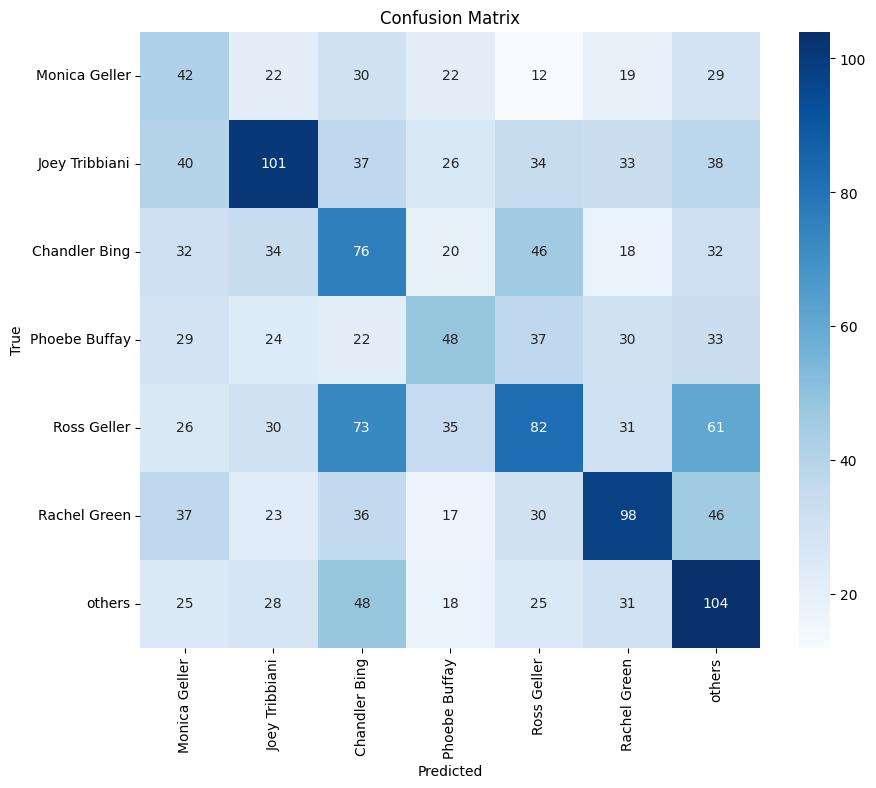

In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

new_real = []

for item in real:
    if item not in ['Monica Geller', 'Joey Tribbiani', 'Chandler Bing', 'Phoebe Buffay', 'Ross Geller', 'Rachel Green']:
        item = 'others'
    new_real.append(item)

conf_matrix = confusion_matrix(new_real, predicted)

# Define a function to plot a colored confusion matrix using Seaborn
def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, characters)

Approach 1

In [11]:
predicted = []
real = []

correct = 0
total = 0

for idx, utterance in enumerate(test_set):
    if len(utterance['speakers']) == 1:

        total += 1

        '''
        if idx == 0:
            line_embed = compute_embedding("", utterance['transcript'])
        else:
            line_embed = compute_embedding(test_set1[idx-1]['transcript'], utterance['transcript'])'''
        
        '''if idx == 0:
            #current, previous, next
            line_embed = compute_embedding2(utterance['transcript'], "" , test_set1[idx+1]['transcript'])
        elif idx == len(test_set)-1:
            line_embed = compute_embedding2(utterance['transcript'], test_set1[idx-1]['transcript'] , "")
        else:
            line_embed = compute_embedding2(utterance['transcript'], test_set1[idx-1]['transcript'] , test_set1[idx+1]['transcript'])'''

        '''
        if idx == 0:
            #current, previous, next
            line_embed = compute_embedding2(utterance['transcript'], "" , "", test_set1[idx+1]['transcript'])
        elif idx == 1:
            line_embed = compute_embedding2(utterance['transcript'], "" , test_set1[idx-1]['transcript'],test_set1[idx+1]['transcript'])
        elif idx == len(test_set)-1:
            line_embed = compute_embedding2(utterance['transcript'],test_set1[idx-2]['transcript'] , test_set1[idx-1]['transcript'] , "")
        else:
            line_embed = compute_embedding2(utterance['transcript'], test_set1[idx-2]['transcript'] , test_set1[idx-1]['transcript'] , test_set1[idx+1]['transcript'])'''
        
        #current, previous2, previous, next, next2
        if idx == 0:
            line_embed = compute_embedding2(utterance['transcript'], "" , "", test_set1[idx+1]['transcript'], test_set1[idx+2]['transcript'])
        elif idx == 1:
            line_embed = compute_embedding2(utterance['transcript'], "" , test_set1[idx-1]['transcript'],test_set1[idx+1]['transcript'], test_set1[idx+2]['transcript'])
        elif idx == len(test_set)-1:
            line_embed = compute_embedding2(utterance['transcript'],test_set1[idx-2]['transcript'] , test_set1[idx-1]['transcript'] , "", "")
        elif idx == len(test_set)-2:
            line_embed = compute_embedding2(utterance['transcript'],test_set1[idx-2]['transcript'] , test_set1[idx-1]['transcript'] , test_set1[idx+1]['transcript'], "")
        else:
            line_embed = compute_embedding2(utterance['transcript'], test_set1[idx-2]['transcript'] , test_set1[idx-1]['transcript'] , test_set1[idx+1]['transcript'], test_set1[idx+2]['transcript'])
    
        pred = compute_similarity(line_embed)

        predicted.append(pred)
        real.append(utterance['speakers'][0])

        if pred == utterance['speakers'][0]:
            correct+=1
        elif pred == "others" and utterance['speakers'][0] not in ['Monica Geller', 'Joey Tribbiani', 'Chandler Bing', 'Phoebe Buffay', 'Ross Geller', 'Rachel Green']:
            correct+=1

                    
print(accuracy_score(real, predicted)*100)

accuracy = (float(correct)/total)*100

print("accuracy: ", accuracy)

#print("f1 score: ", f1_score(real, predicted, average='macro'))


13.862502012558364
accuracy:  18.33843181452262
